In [2]:
!pip install pytorch-forecasting
import warnings
#!pip install ucimlrepo
#!pip install openpyxl
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 11.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
data= pd.read_excel("/kaggle/input/airqualityuci/AirQualityUCI.xlsx")

In [5]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [6]:
x=data.isnull().sum()
x

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

## Continuos Feature Report

In [7]:
numeric_features= data.select_dtypes(include=[np.number])
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

build_continuous_features_report(data)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
CO(GT),9357,0.0,97,-200.0,0.600000,-34.207524,1.500000,2.600000,11.900000,77.657170
PT08.S1(CO),9357,0.0,3246,-200.0,921.000000,1048.869652,1052.500000,1221.250000,2039.750000,329.817015
NMHC(GT),9357,0.0,430,-200.0,-200.000000,-159.090093,-200.000000,-200.000000,1189.000000,139.789093
C6H6(GT),9357,0.0,3773,-200.0,4.004958,1.865576,7.886653,13.636091,63.741476,41.380154
PT08.S2(NMHC),9357,0.0,3773,-200.0,711.000000,894.475963,894.500000,1104.750000,2214.000000,342.315902
NOx(GT),9357,0.0,2467,-200.0,50.000000,168.604200,141.000000,284.200000,1479.000000,257.424561
PT08.S3(NOx),9357,0.0,3519,-200.0,637.000000,794.872333,794.250000,960.250000,2682.750000,321.977031
NO2(GT),9357,0.0,1420,-200.0,53.000000,58.135898,96.000000,133.000000,339.700000,126.931428
PT08.S4(NO2),9357,0.0,4408,-200.0,1184.750000,1391.363266,1445.500000,1662.000000,2775.000000,467.192382
PT08.S5(O3),9357,0.0,4679,-200.0,699.750000,974.951534,942.000000,1255.250000,2522.750000,456.922728


# Exploratory Data Analysis(EDA)

In [8]:
import pandas as pd

# Define the data for the table
df = {
    'Variable Name': ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)'],
    'Role': ['Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature'],
    'Type': ['Date', 'Categorical', 'Integer', 'Categorical', 'Integer', 'Continuous', 'Categorical', 'Integer', 'Categorical', 'Integer'],
    'Description': [
        'Date of the measurement',
        'Time of the measurement',
        'True hourly averaged concentration of CO in mg/m³ (reference analyzer)',
        'Hourly averaged sensor response (nominal CO targeted)',
        'True hourly averaged overall Non-Methanic HydroCarbons concentration in microg/m³ (reference analyzer)',
        'True hourly averaged Benzene concentration in microg/m³ (reference analyzer)',
        'Hourly averaged sensor response (nominal NMHC targeted)',
        'True hourly averaged NOx concentration in ppb (reference analyzer)',
        'Hourly averaged sensor response (nominal NOx targeted)',
        'True hourly averaged NO2 concentration in microg/m³ (reference analyzer)'
    ],
    'Units': ['N/A', 'N/A', 'mg/m³', 'N/A', 'microg/m³', 'microg/m³', 'N/A', 'ppb', 'N/A', 'microg/m³']
}

# Create DataFrame
df_description = pd.DataFrame(df)

# Display the DataFrame
print(df_description)


   Variable Name     Role         Type  \
0           Date  Feature         Date   
1           Time  Feature  Categorical   
2         CO(GT)  Feature      Integer   
3    PT08.S1(CO)  Feature  Categorical   
4       NMHC(GT)  Feature      Integer   
5       C6H6(GT)  Feature   Continuous   
6  PT08.S2(NMHC)  Feature  Categorical   
7        NOx(GT)  Feature      Integer   
8   PT08.S3(NOx)  Feature  Categorical   
9        NO2(GT)  Feature      Integer   

                                         Description      Units  
0                            Date of the measurement        N/A  
1                            Time of the measurement        N/A  
2  True hourly averaged concentration of CO in mg...      mg/m³  
3  Hourly averaged sensor response (nominal CO ta...        N/A  
4  True hourly averaged overall Non-Methanic Hydr...  microg/m³  
5  True hourly averaged Benzene concentration in ...  microg/m³  
6  Hourly averaged sensor response (nominal NMHC ...        N/A  
7  True h

In [9]:
data['datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

#data.set_index('datetime',inplace=True)
data.drop(['Date','Time'],axis = 1,inplace = True)

In [10]:
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00


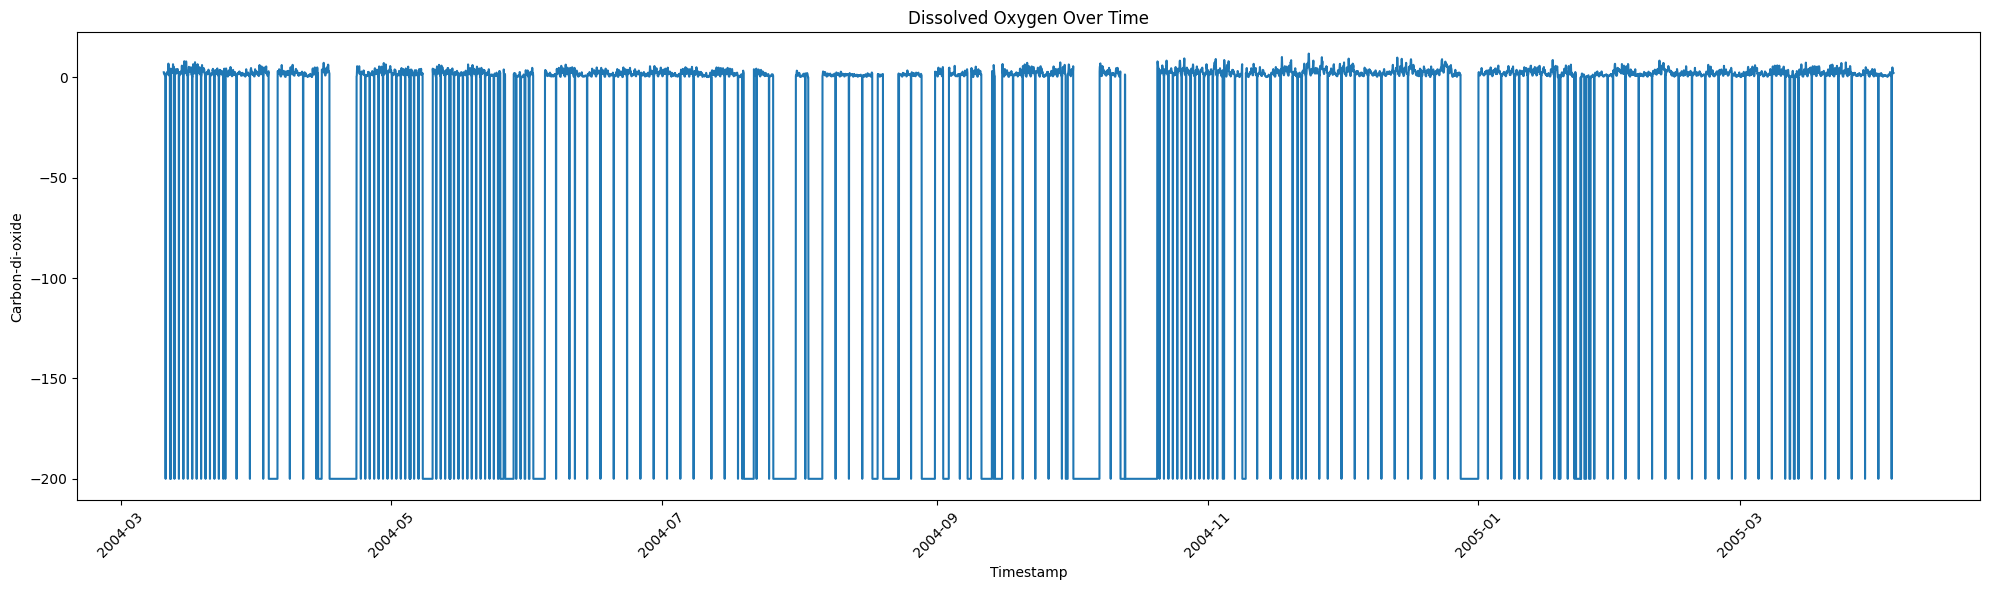

In [11]:
plt.figure(figsize=(16, 6))  # Adjust the size as needed  linestyle='-', color='blue'
plt.plot(data['datetime'], data['CO(GT)'] )
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Carbon-di-oxide')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [46]:
count_negative_200 = len(data[data['CO(GT)'] == -200])
count_negative_200

0

From the above plot we can see that th

In [26]:
total_counts = numeric_features.count()
negative_value_counts = (numeric_features < 0).sum()

percentage_negative = (negative_value_counts / total_counts) * 100

results_df = pd.DataFrame({
    'Total_Count': total_counts,
    'Negative_Count': negative_value_counts,
    'Percentage_Negative': percentage_negative
})

print("Number of negative values in each numeric column:")
print(results_df)

Number of negative values in each numeric column:
               Total_Count  Negative_Count  Percentage_Negative
CO(GT)                9357            1683            17.986534
PT08.S1(CO)           9357             366             3.911510
NMHC(GT)              9357            8443            90.231912
C6H6(GT)              9357             366             3.911510
PT08.S2(NMHC)         9357             366             3.911510
NOx(GT)               9357            1639            17.516298
PT08.S3(NOx)          9357             366             3.911510
NO2(GT)               9357            1642            17.548360
PT08.S4(NO2)          9357             366             3.911510
PT08.S5(O3)           9357             366             3.911510
T                     9357             380             4.061131
RH                    9357             366             3.911510
AH                    9357             366             3.911510


In [12]:
negative_values = data[data['CO(GT)'] < 0]
print('The precentage of CO2 having negative value',len(negative_values)/len(data['CO(GT)'])*100)

The precentage of CO2 having negative value 17.986534145559474


In [13]:
total_counts = numeric_features.count()
negative_value_counts = (numeric_features < 0).sum()

percentage_negative = (negative_value_counts / total_counts) * 100

results_df = pd.DataFrame({
    'Total_Count': total_counts,
    'Negative_Count': negative_value_counts,
    'Percentage_Negative': percentage_negative
})

print("Number of negative values in each numeric column:")
print(results_df)

Number of negative values in each numeric column:
               Total_Count  Negative_Count  Percentage_Negative
CO(GT)                9357            1683            17.986534
PT08.S1(CO)           9357             366             3.911510
NMHC(GT)              9357            8443            90.231912
C6H6(GT)              9357             366             3.911510
PT08.S2(NMHC)         9357             366             3.911510
NOx(GT)               9357            1639            17.516298
PT08.S3(NOx)          9357             366             3.911510
NO2(GT)               9357            1642            17.548360
PT08.S4(NO2)          9357             366             3.911510
PT08.S5(O3)           9357             366             3.911510
T                     9357             380             4.061131
RH                    9357             366             3.911510
AH                    9357             366             3.911510


In [30]:
# Dropped NMHC(GT) because it has 90.231912% negative values. Parti
data.drop(['NMHC(GT)'],axis = 1,inplace = True)
numeric_features = data.select_dtypes(include=[np.number])

# Replacing the nagtive values with Nan
numeric_features = numeric_features.mask(numeric_features < 0)

# Impute NaN values with median
numeric_features = numeric_features.fillna(numeric_features.median())

# Update 'data' DataFrame with imputed values
data[numeric_features.columns] = numeric_features


In [31]:

total_counts = numeric_features.count()
negative_value_counts = (numeric_features < 0).sum()


percentage_negative = (negative_value_counts / total_counts) * 100


results_df = pd.DataFrame({
    'Total_Count': total_counts,
    'Negative_Count': negative_value_counts,
    'Percentage_Negative': percentage_negative
})

print("Number of negative values in each numeric column after processing:")
print(results_df)

Number of negative values in each numeric column after processing:
               Total_Count  Negative_Count  Percentage_Negative
CO(GT)                9357               0                  0.0
PT08.S1(CO)           9357               0                  0.0
C6H6(GT)              9357               0                  0.0
PT08.S2(NMHC)         9357               0                  0.0
NOx(GT)               9357               0                  0.0
PT08.S3(NOx)          9357               0                  0.0
NO2(GT)               9357               0                  0.0
PT08.S4(NO2)          9357               0                  0.0
PT08.S5(O3)           9357               0                  0.0
T                     9357               0                  0.0
RH                    9357               0                  0.0
AH                    9357               0                  0.0


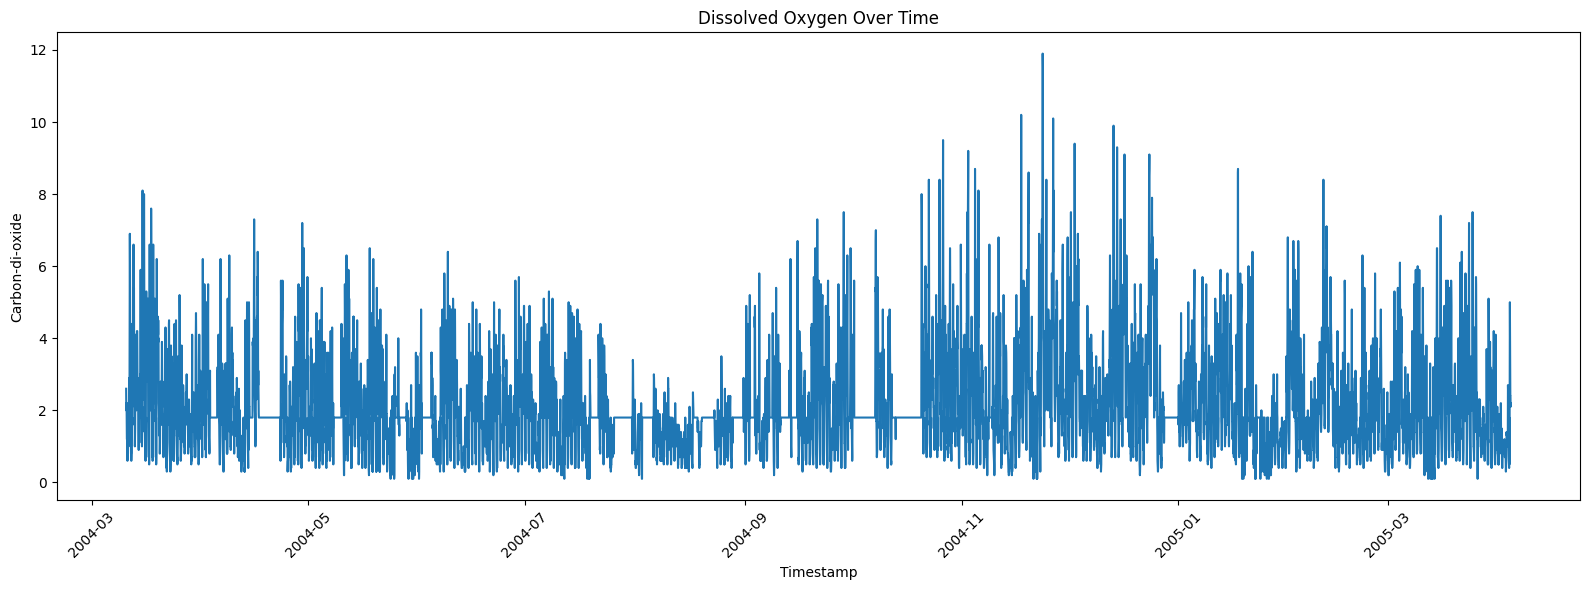

In [49]:
plt.figure(figsize=(16, 6))  
plt.plot(data['datetime'], data['CO(GT)'] )
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Carbon-di-oxide')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [38]:
data.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
datetime         0
dtype: int64